__author__ = "Elias El Otmani"
__credits__ = "Thomas Fontaine"
__email__ = "elias.el.otmani@ens.psl.eu"

Description : Training of a density estimator on pre-simulated data. Analysis of the subsequent posterior density. 

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import torch, os, pickle
from sbi.inference import SNPE
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
#from sbi import analysis as analysis

## Data acquisition & pre-processing

In [12]:
presimulated_data1 = os.listdir('inference_data/round4/')
#presimulated_data2 = os.listdir('inference_data/round2/')
x = []

for file_name in presimulated_data1:
    with open('inference_data/round4/' + file_name, 'rb') as f:
        x.append(np.load(f))
'''
for file_name in presimulated_data2 :
    with open('inference_data/round2/' + file_name, 'rb') as f:
        x.append(np.load(f))
'''
x = np.vstack(x)

print(x.shape)

(110000, 26)


In [13]:
notnan_data = []
notnan_theta = []
for array in x : 
    if not np.isnan(array).any(): 
        notnan_data.append(array[:11])
        notnan_theta.append(array[11:])

In [14]:
data = torch.as_tensor(notnan_data, dtype = torch.float32)
theta = torch.as_tensor(notnan_theta, dtype = torch.float32)

## First explorations

In [15]:
computer = "cpu"
enc = torch.float64
dev = torch.device(computer)

x_o = torch.as_tensor([1.75, 1.04, 1.12, 1.33, 60.2, 35.3, 35.2, 68.8, 21.7, 4.2, 1.5], device=dev, dtype=torch.float64)

dist = []
for stats in data: 
    dist.append(np.linalg.norm(stats-x_o))
dist = np.sort(dist)


Minimal distance :		 36.55448437777938

Corresponding data :

 tensor([ 7.5910e+00,  5.7077e-03,  1.2787e+02,  8.1399e-01,  7.7858e+01,
         8.6682e+00,  4.9896e+02, -4.7588e-02,  3.3529e-02,  1.1191e+01,
         0.0000e+00])

Correspondings parameters

 tensor([92.9750, 64.9393, 42.0416, 23.0585, 90.7832, 88.2112, 92.2806, 29.5923,
        25.9561, 64.4376,  9.4528,  5.4128,  1.8767,  0.8784,  0.8322])


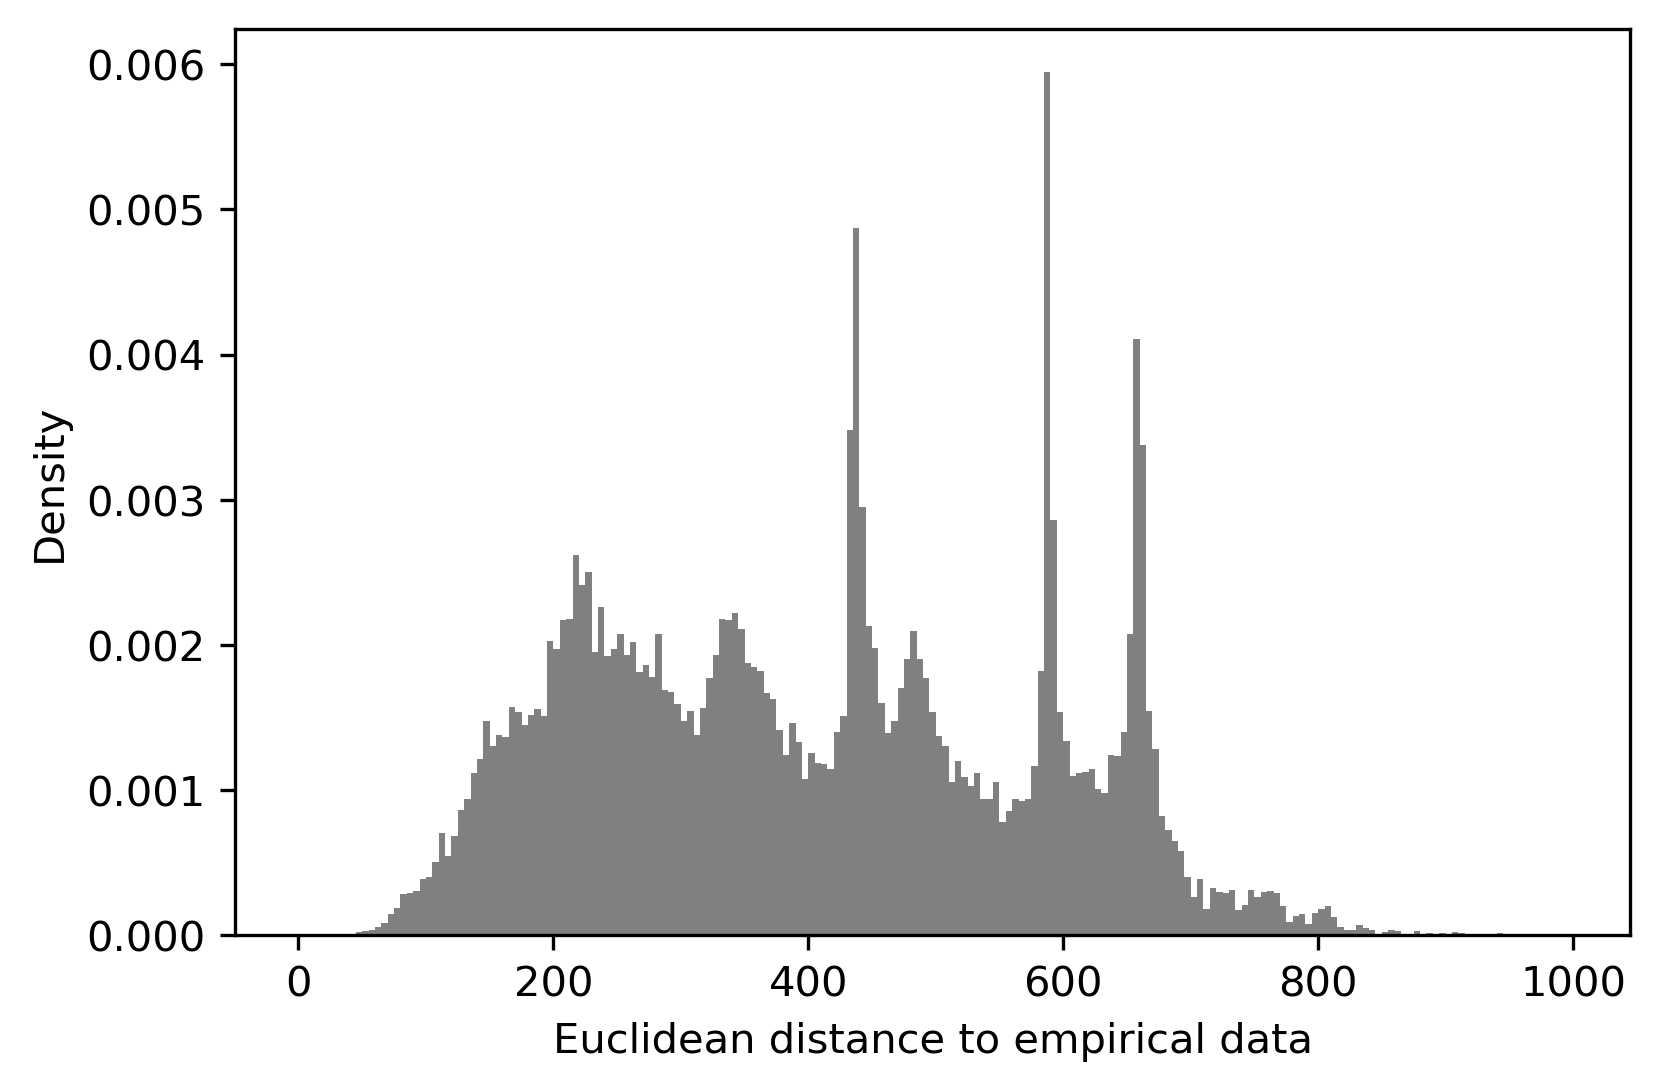

In [19]:
plt.figure(dpi = 300)
plt.hist(dist, bins = [5*i for i in range(200)], color = 'gray', density = True)
plt.xlabel('Euclidean distance to empirical data')
plt.ylabel('Density')
print('\nMinimal distance :\t\t', min(dist))
print('\nCorresponding data :\n\n', data[list(dist).index(min(dist))])
print('\nCorrespondings parameters\n\n', theta[list(dist).index(min(dist))])

plt.savefig('plots/Fig1/D-params_data_euclidean_distances_distribution.jpg', dpi = 300)

## Training neural network

In [34]:
theta.shape

torch.Size([20000, 15])

In [13]:
dim = 15 # Number of degrees of freedom of the simulator [w_xy (10), I_ext-x (4), J_adp]

# PRIORS
mW, mI, mP = [.1 for k in range(10)], [.1 for k in range(4)], [0]
MW, MI, MP = [100. for k in range(10)], [10. for k in range(4)], [1] 
priors_min, priors_max = np.concatenate((mW, mI, mP)), np.concatenate((MW, MI, MP))
priors = np.array([priors_min, priors_max])

prior_min = torch.as_tensor(priors_min, device=dev, dtype=torch.float64)
prior_max = torch.as_tensor(priors_max, device=dev, dtype=torch.float64)
    
prior = utils.BoxUniform(low=prior_min, high=prior_max)

In [14]:
inference = SNPE(prior=prior)

density_estimator = inference.append_simulations(theta, data, proposal=prior).train()
posterior = inference.build_posterior(density_estimator)

            set to cpu, moving data to device to cpu.


Neural network successfully converged after 20 epochs.


## Plotting log probs

In [16]:
#x_o = torch.as_tensor([27.5, 5.62, 5.6, 21.5, 1.75, 1.04, 1.12, 1.33, 60.2, 35.3, 35.2, 68.8, 21.7, 4.2, 1.5], device=dev, dtype=torch.float64)
x_o = torch.as_tensor([1.75, 1.04, 1.12, 1.33, 60.2, 35.3, 35.2, 68.8, 21.7, 4.2, 1.5], device=dev, dtype=torch.float64)

In [10]:
posterior_samples = post2.sample((10000,), x=x_o, sample_with_mcmc = True)

Generating samples: 100%|██████████████████████████████████████████████████████| 10000/10000 [5:20:58<00:00,  1.93s/it]


<Figure size 1800x1200 with 0 Axes>

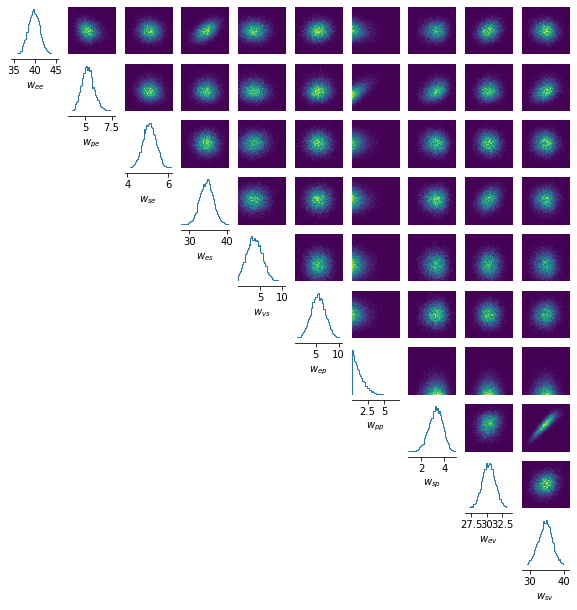

In [9]:
# Adapted from THOMAS
#A, W, I, P = [k for k in range(10)], [k for k in range(4, 14)], [k for k in range(14, 18)], [k for k in range(18, 22)]
W, I = [k for k in range(10)], [k for k in range(10, 15)]
lab_W = ['$w_{ee}$', '$w_{pe}$', '$w_{se}$', '$w_{es}$', '$w_{vs}$', '$w_{ep}$', '$w_{pp}$', '$w_{sp}$', '$w_{ev}$', '$w_{sv}$']
lab_I = ['$I_{ext-e}$', '$I_{ext-p}$', '$I_{ext-s}$', '$I_{ext-v}$', '$J_{adp}$']
labs = np.concatenate((lab_W, lab_I))
plt.figure(dpi = 300)
_ = utils.pairplot(posterior_samples[:,W], labels=lab_W, dpi = 300)
plt.savefig('plots/Fig1/A-inference_plot_W.png', bbox_inches='tight', dpi = 300)

C:\Users\elias\anaconda3\envs\sbi_github\lib\site-packages\sbi\utils\plot.py:181: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  "Importing `pairplot` from `sbi.utils` is deprecated since sbi "


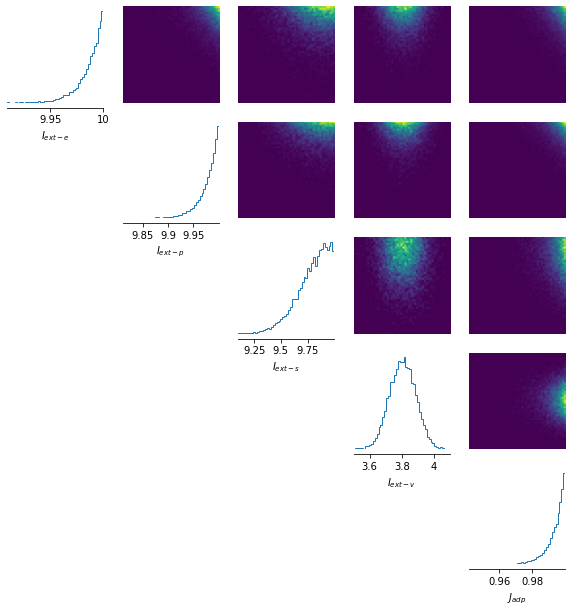

In [35]:
_ = utils.pairplot(posterior_samples[:,I], labels=lab_I)
plt.savefig('C:/Users/elias/Desktop/CogSci/Internship/Code/plots/inference_plot_I.png', bbox_inches='tight')

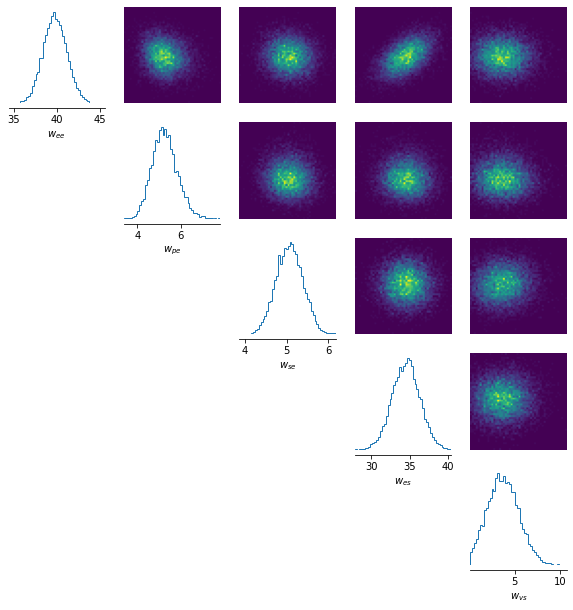

In [37]:
_ = utils.pairplot(posterior_samples[:,W[:5]], labels=lab_W[:5])
plt.savefig('C:/Users/elias/Desktop/CogSci/Internship/Code/plots/inference_plot_W1.png', bbox_inches='tight')

C:\Users\elias\anaconda3\envs\sbi_github\lib\site-packages\sbi\utils\plot.py:181: UserWarning: Importing `pairplot` from `sbi.utils` is deprecated since sbi v0.15.0. Instead, use `from sbi.analysis import pairplot`.
  "Importing `pairplot` from `sbi.utils` is deprecated since sbi "


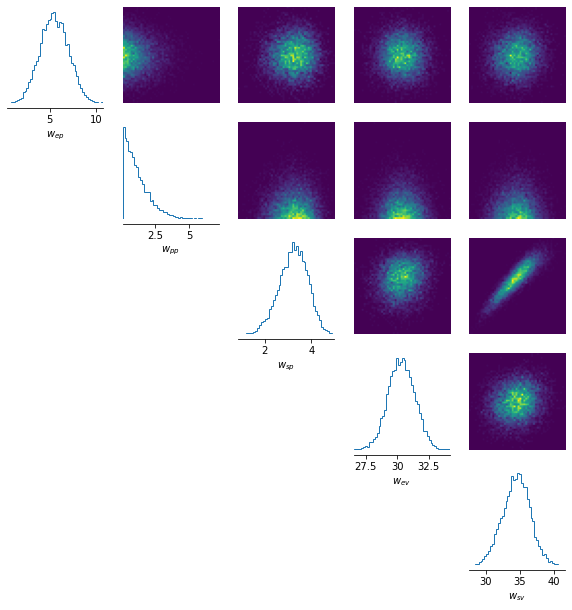

In [38]:
_ = utils.pairplot(posterior_samples[:,W[5:10]], labels=lab_W[5:10])
plt.savefig('C:/Users/elias/Desktop/CogSci/Internship/Code/plots/inference_plot_W2.png', bbox_inches='tight')

## Max likelihood parameter set

In [42]:
log_probability = post2.log_prob(posterior_samples, x=x_o, norm_posterior = False).numpy()

In [43]:
print(posterior_samples[log_probability.argmax()])

tensor([39.7677,  4.7255,  4.9317, 33.0914,  2.5964,  5.5552,  0.4989,  3.1944,
        29.9229, 34.0033,  9.9989, 10.0000,  9.9651,  3.7941,  0.9980])


## Savings & draft zone

In [15]:
with open(os.getcwd() + 'neural_nets/posterior210509_1_', "wb") as handle:
    pickle.dump(posterior, handle)

In [4]:
with open('neural_nets/posterior210509_1', "rb") as handle:
    post2 = pickle.load(handle)

In [13]:
toSave = posterior_samples.numpy()
with open('posteriorSamples.npy', 'wb') as f:
    np.save(f, toSave)

In [5]:
with open('posteriorSamples.npy', 'rb') as f:
    posterior_samples = np.load(f)

In [28]:
torch.__version__

'1.8.0+cpu'

In [11]:
posterior_samples

tensor([[41.2647,  5.8517,  5.0321,  ...,  9.7510,  3.8227,  0.9977],
        [39.2128,  5.0857,  4.6940,  ...,  9.8414,  3.9399,  0.9976],
        [39.4394,  5.8165,  5.0017,  ...,  9.3888,  3.7051,  0.9948],
        ...,
        [40.6333,  4.7201,  4.9292,  ...,  9.7242,  3.8941,  0.9977],
        [41.4201,  6.0270,  5.1414,  ...,  9.6770,  3.9609,  0.9993],
        [43.0307,  4.6523,  5.2066,  ...,  9.9526,  3.8800,  0.9926]])